# Mass-Spring-Damper System: Postprocessing the DeepONet

In [1]:
### Importing Libraries

import sys
print(sys.version)
import os
import time


### Defining WORKSPACE_PATH

# WORKSPACE_PATH = os.environ['WORKSPACE_PATH']
WORKSPACE_PATH = os.path.join(os.getcwd(), '../../../../../../')
ROMNet_fld     = os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/')

### Importing External Libraries

import numpy                             as np
import pandas                            as pd


### Importing Matplotlib and Its Style

import matplotlib.pyplot                 as plt

#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/presentation.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/zoomed.mplstyle'))
plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_1column.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_2columns.mplstyle'))


from scipy.integrate import solve_ivp
import pyDOE
from PCAfold         import PCA          as PCAA


import romnet                            as rmnt

3.8.11 (default, Jun 29 2021, 03:17:05) 
[Clang 12.0.0 (clang-1200.0.32.29)]


Missing colon in file PosixPath('/Users/sventur/.matplotlib/stylelib/paper_2columns.mplstyle'), line 1 ('f#### MATPLOTLIBRC FORMAT')


## ODE

In [2]:
def fOrig(t, y):
    return [y[1], -Params[2]/Params[0]*y[0]-Params[1]/Params[0]*y[1]]

def fOrig_Source(t, y):
    return [y[1], -Params[2]/Params[0]*y[0]-Params[1]/Params[0]*y[1]]

Params = np.array([1.0, 0.5, 3.0], dtype=np.float64)

## Defining Input Data

In [3]:
path_to_run_fld = os.path.join(WORKSPACE_PATH, 'ROMNet/MSD_50Cases_wNoise_All_5em2t/DeepONet/Run_6/')
#path_to_run_fld = os.path.join(WORKSPACE_PATH, 'ROMNet/MSD_50Cases_wNoise_All_5em2t/VI_DeepONet/Run_6/')

FigDir          = os.path.join(WORKSPACE_PATH, '../Desktop/Paper_Figures_DeepONet_TEMP/')


TrainingCases   = [0]#[0,2,4,6,8]
TestCases       = [0,2,4]#[0,2]

NSamples        = 200

Nt              = 100
tout            = np.linspace(0.,15.,Nt)
SOLVER          = 'Radau'


LineVec         = ['-',':','--','.-']*10
ColorVec        = ['#190707', '#dd3232', '#0065a9', '#348a00','#985396','#f68b69']

## Loading ROMNet's Input Data File

In [4]:
print("\n[ROMNet]: Reading Input File from: ", path_to_run_fld)
sys.path.insert(0, path_to_run_fld)

print("\n[ROMNet]: Keep Loading Modules and Functions...")
from ROMNet_Input import inputdata

print("\n[ROMNet]: Initializing Input ...")
InputData               = inputdata(WORKSPACE_PATH)


InputData.InputFilePath = path_to_run_fld+'/ROMNet_Input.py'
InputData.train_int_flg = 0
InputData.path_to_run_fld  = path_to_run_fld


[ROMNet]: Reading Input File from:  /Users/sventur/WORKSPACE/ROMNet/romnet/scripts/postprocessing/MassSpringDamper/DeepONet/../../../../../../ROMNet/MSD_50Cases_wNoise_All_5em2t/DeepONet/Run_6/

[ROMNet]: Keep Loading Modules and Functions...

[ROMNet]: Initializing Input ...


## Loading Tensorflow's Model for the Network 

In [5]:
surrogate_type = InputData.surrogate_type
if (surrogate_type == 'FNN-SourceTerms'):
    surrogate_type = 'FNN'

Net   = getattr(rmnt.nn, surrogate_type)

model = rmnt.model.Model_TF(InputData)

if (InputData.phys_system is not None):
    System = getattr(rmnt.pinn.system, InputData.phys_system)
    system = System(InputData)
    
model.build(InputData, None, Net, system)#, loadfile_no='000027')

NN    = model.net


[ROMNet - model_tf.py    ]:   Initializing the ML Model

[ROMNet - model_tf.py    ]:   Building the ML Model

[ROMNet - deeponet.py               ]:   Constructing Deep Operator Network: 
[ROMNet - system_of_components.py   ]:     Mapping Branch-to-Trunk (i.e., self.branch_to_trunk Object):  [0 1]
[ROMNet - system_of_components.py   ]:     Constructing System of Components: DeepONet
[ROMNet - component.py              ]:       Constructing Component: Branch_1
[ROMNet - sub_component.py          ]:         Constructed Sub-Component: Main with Layers:       ListWrapper([<romnet.nn.building_blocks.normalization.CustomNormalization object at 0x16123eb80>, <keras.layers.core.dense.Dense object at 0x1614bb850>, <keras.layers.core.dropout.Dropout object at 0x161491b80>, <keras.layers.core.dense.Dense object at 0x161491ca0>, <keras.layers.core.dropout.Dropout object at 0x161491310>, <keras.layers.core.dense.Dense object at 0x16144ec70>, <keras.layers.core.dropout.Dropout object at 0x161491040


[ROMNet - model_tf.py    ]:   Saving ML Model Parameters to File:  /Users/sventur/WORKSPACE/ROMNet/romnet/scripts/postprocessing/MassSpringDamper/DeepONet/../../../../../../ROMNet/MSD_50Cases_wNoise_All_5em2t/DeepONet/Run_6//Model/Params/Initial.h5
'save_params' took 0.034349 s

'build' took 1.795850 s



## Evaluating DeepONet on Test Data

In [6]:
if (InputData.surrogate_type == 'DeepONet'):
    ModelType = 'DeepONet'
elif (InputData.surrogate_type == 'VI_DeepONet'):
    ModelType = 'DeepONetMean'

input_vars  = model.net.input_vars
trunk_vars  = InputData.input_vars[ModelType]['Trunk']
branch_vars = InputData.input_vars[ModelType]['Branch']

FileName  = WORKSPACE_PATH + '/ROMNet/Data/MSD_100Cases/Orig/test/ext/Input.csv'# + InputData.InputFile
Data      = pd.read_csv(FileName, header=0)
Input     = Data[branch_vars].to_numpy()
VarNames  = list(Data.columns)
Nu        = Input.shape[1]
u         = []
for iu in range(Nu):
    u.append(np.unique(Input[:,iu]))
u         = np.stack(u, axis=0).T
u

array([[-3.6, -3.6],
       [-2.8, -2.8],
       [-2. , -2. ],
       [-1.2, -1.2],
       [-0.4, -0.4],
       [ 0.4,  0.4],
       [ 1.2,  1.2],
       [ 2. ,  2. ],
       [ 2.8,  2.8],
       [ 3.6,  3.6]])

iVar =  1
u0 =  [-3.6 -3.6]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


u0 =  [-2.8 -2.8]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


u0 =  [-2. -2.]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


u0 =  [-1.2 -1.2]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


u0 =  [-0.4 -0.4]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


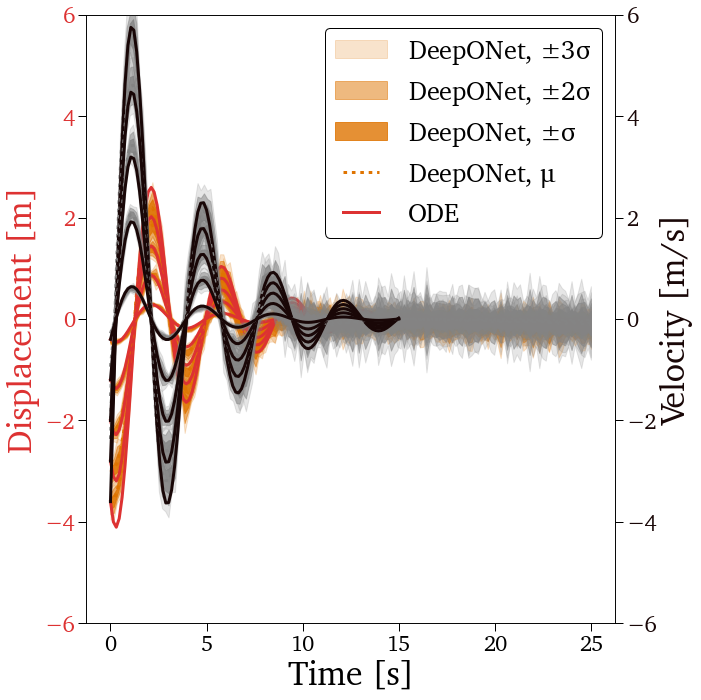

In [7]:
### Evaluating on Test Data

FileName  = WORKSPACE_PATH + '/ROMNet/Data/MSD_100Cases/Orig/test/ext/Input.csv'# + InputData.InputFile
Data      = pd.read_csv(FileName, header=0)
Input     = Data[branch_vars].to_numpy()
VarNames  = list(Data.columns)
Nu        = Input.shape[1]
u         = []
for iu in range(Nu):
    u.append(np.unique(Input[:,iu]))
u         = np.stack(u, axis=0).T


## Variable to Be Visualized
VarOI     = 'x'
for iVar in range(1,len(VarNames)):
    if (VarNames[iVar] == VarOI):
        print('iVar = ', iVar)
        break

iSim     = 0
fig, ax1 = plt.subplots()
ax2      = ax1.twinx()  # instantiate a second axes that shares the same x-axis
for iTest in [0,1,2,3,4]:
    
    print('u0 = ', u[iTest,:])

    ### Generating Data  
    output     = solve_ivp( fOrig, tout[[0,-1]], u[iTest,:], method=SOLVER, t_eval=tout, rtol=1.e-15, atol=1.e-10 )
    tOrig      = tout
    yMatOrig   = output.y.T
    
    ### Creating NN Input
    tPred     = np.linspace(0,25,150)[...,np.newaxis] #tOrig[...,np.newaxis]
    Nt        = tPred.shape[0]
    uPred     = u[iTest,:]*np.ones((Nt,2))
    InputPred = np.concatenate((uPred,tPred), axis=1)


    ### Sampling NN
    yMat_sum = np.zeros((tPred.shape[0], 2))
    yMat_sqr = np.zeros((tPred.shape[0], 2))

    for iSample in range(NSamples):
        yMat_     = model.predict(InputPred)    
        yMat_sum += yMat_
        yMat_sqr += yMat_**2
#         ax1.plot(tPred, yMat_[:,iVar-1], '-',  color='#DF7401', label=None, linewidth=0.5)
#         ax2.plot(tPred, yMat_[:,iVar],   '-',  color='#848484', label=None, linewidth=0.5)

    yMat_mean = yMat_sum/NSamples
    yMat_std  = np.sqrt( yMat_sqr/NSamples - yMat_mean**2 )
    yMat_p1   = yMat_mean + 1.*yMat_std
    yMat_m1   = yMat_mean - 1.*yMat_std
    yMat_p2   = yMat_mean + 2.*yMat_std
    yMat_m2   = yMat_mean - 2.*yMat_std
    yMat_p3   = yMat_mean + 3.*yMat_std
    yMat_m3   = yMat_mean - 3.*yMat_std


    if (iSim == 0):
        Label1 = 'ODE'
        Label2 = 'DeepONet, $\mu$'
        Label3 = 'DeepONet, $\pm 3\sigma$'
        Label4 = 'DeepONet, $\pm 2\sigma$'
        Label5 = 'DeepONet, $\pm \sigma$'
    else:
        Label1 = None
        Label2 = None
        Label3 = None
        Label4 = None
        Label5 = None


    color = ColorVec[1]
    ax1.fill_between(tPred[:,0], yMat_m3[:,iVar-1], yMat_p3[:,iVar-1], alpha=.2, color='#DF7401', label=Label3)
    ax1.fill_between(tPred[:,0], yMat_m2[:,iVar-1], yMat_p2[:,iVar-1], alpha=.5, color='#DF7401', label=Label4)
    ax1.fill_between(tPred[:,0], yMat_m1[:,iVar-1], yMat_p1[:,iVar-1], alpha=.8, color='#DF7401', label=Label5)
    ax1.plot(tPred, yMat_mean[:,iVar-1], ':',  color='#DF7401', label=Label2)
    ax1.plot(tOrig, yMatOrig[:,iVar-1],  '-',  color=color,     label=Label1)

    color = ColorVec[0]
    ax2.fill_between(tPred[:,0], yMat_m3[:,iVar], yMat_p3[:,iVar], alpha=.2, color='#848484', label=None)
    ax2.fill_between(tPred[:,0], yMat_m2[:,iVar], yMat_p2[:,iVar], alpha=.5, color='#848484', label=None)
    ax2.fill_between(tPred[:,0], yMat_m1[:,iVar], yMat_p1[:,iVar], alpha=.8, color='#848484', label=None)
    ax2.plot(tPred, yMat_mean[:,iVar], ':', color='#848484',  label=None)
    ax2.plot(tOrig, yMatOrig[:,iVar],  '-', color=color,      label=None)

    iSim += 1


ax1.set_xlabel('Time [s]', size=34)
ax1.set_ylabel('Displacement [m]', color=ColorVec[1], size=34)
ax1.tick_params(axis='y', labelcolor=ColorVec[1])
ax1.set_ylim([-6.,6.])

color = 'k'
ax2.set_ylabel('Velocity [m/s]', color=ColorVec[0], size=34)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=ColorVec[0])
ax2.set_ylim([-6.,6.])

ax1.legend()

fig.tight_layout()  # otherwise the right y-label is slightly clipped

if (FigDir):
    plt.savefig(FigDir+'/MSD_TrainedDynamics_DeepONet_Dropout.png', format='png', bbox_inches='tight')
    #plt.savefig(FigDir+'/MSD_TrainedDynamics_PINN.eps', format='eps', bbox_inches='tight')
    #plt.savefig(FigDir+'/MSD_TrainedDynamics_SVD.eps', format='eps', bbox_inches='tight')
    #plt.savefig(FigDir+'/MSD_TrainedDynamics_PCA_All.eps', format='eps', bbox_inches='tight')
    pass

In [8]:
### EXPERIMENTING

# FileName  = WORKSPACE_PATH + '/ROMNet/Data/MSD_100Cases/Orig/test/ext/Input.csv'# + InputData.InputFile
# Data      = pd.read_csv(FileName, header=0)
# Input     = Data[branch_vars].to_numpy()
# VarNames  = list(Data.columns)
# Nu        = Input.shape[1]
# u         = []
# for iu in range(Nu):
#     u.append(np.unique(Input[:,iu]))
# u         = np.stack(u, axis=0).T



# CostVec_Int = []

# iSim = 0
# for iTest in [0,1,2,3,4]:
    
#     print('u0 = ', u[iTest,:])
    
#     t0 = time.time()
#     ### Generating Data  
#     output     = solve_ivp( fOrig, tout[[0,-1]], u[iTest,:], method=SOLVER, t_eval=tout, rtol=1.e-15, atol=1.e-10 )
#     t1 = time.time()
#     CostVec_Int.append(t1-t0)
    

#     iSim += 1

In [9]:
# CostVec_Loop = []

# iTestVec     = [0,1,2,3,4]

# tLoop        = np.linspace(0.,15.,3)

# iSim = 0
# for iTest in iTestVec:
    
#     print('u0 = ', u[iTest,:])
    
#     t0 = time.time()
#     yMatLoop      = np.zeros((len(tLoop),2))
#     InputPredLoop = np.concatenate([u[iTest,:][np.newaxis,...], (tLoop[0])[np.newaxis,np.newaxis]], axis=1)
#     yMatLoop[0,:] = model.net.predict(InputPredLoop)
#     for it, tLoop_ in enumerate(tLoop[1:]):
#         InputPredLoop    = np.concatenate([yMatLoop[it,:][np.newaxis,...], (tLoop[it+1]-tout[it])[np.newaxis,np.newaxis]], axis=1)
#         yMatLoop[it+1,:] = model.net.predict(InputPredLoop)

#     t1 = time.time()
#     CostVec_Loop.append(t1-t0)
    
#     plt.plot(tLoop, yMatLoop[:,iVar-1], 'b')
#     plt.xlabel('t')
#     plt.ylabel(VarOI)
#     plt.legend()
#     #plt.show()
    
#     iSim += 1

In [10]:
# Cost_Loop     = 0.

# iTestVec      = [0,1,2,3,4]*10
# n_test         = len(iTestVec)
    


# InputPredLoop = np.concatenate([u[iTestVec,:], np.array([tLoop[0]]*n_test)[...,np.newaxis]], axis=1)
# yMatLoop      = model.net.predict(InputPredLoop)
# yMatLoopAll   = []
# for it, tLoop_ in enumerate(tLoop[1:]):
#     InputPredLoop = np.concatenate([yMatLoop, np.array([tLoop[it+1]-tLoop[it]]*n_test)[...,np.newaxis]], axis=1)
#     t0            = time.time()
#     yMatLoop      = model.net.predict(InputPredLoop)
#     t1            = time.time()
#     Cost_Loop    += t1-t0
#     yMatLoopAll.append(yMatLoop)

## Plotting Loss Histories

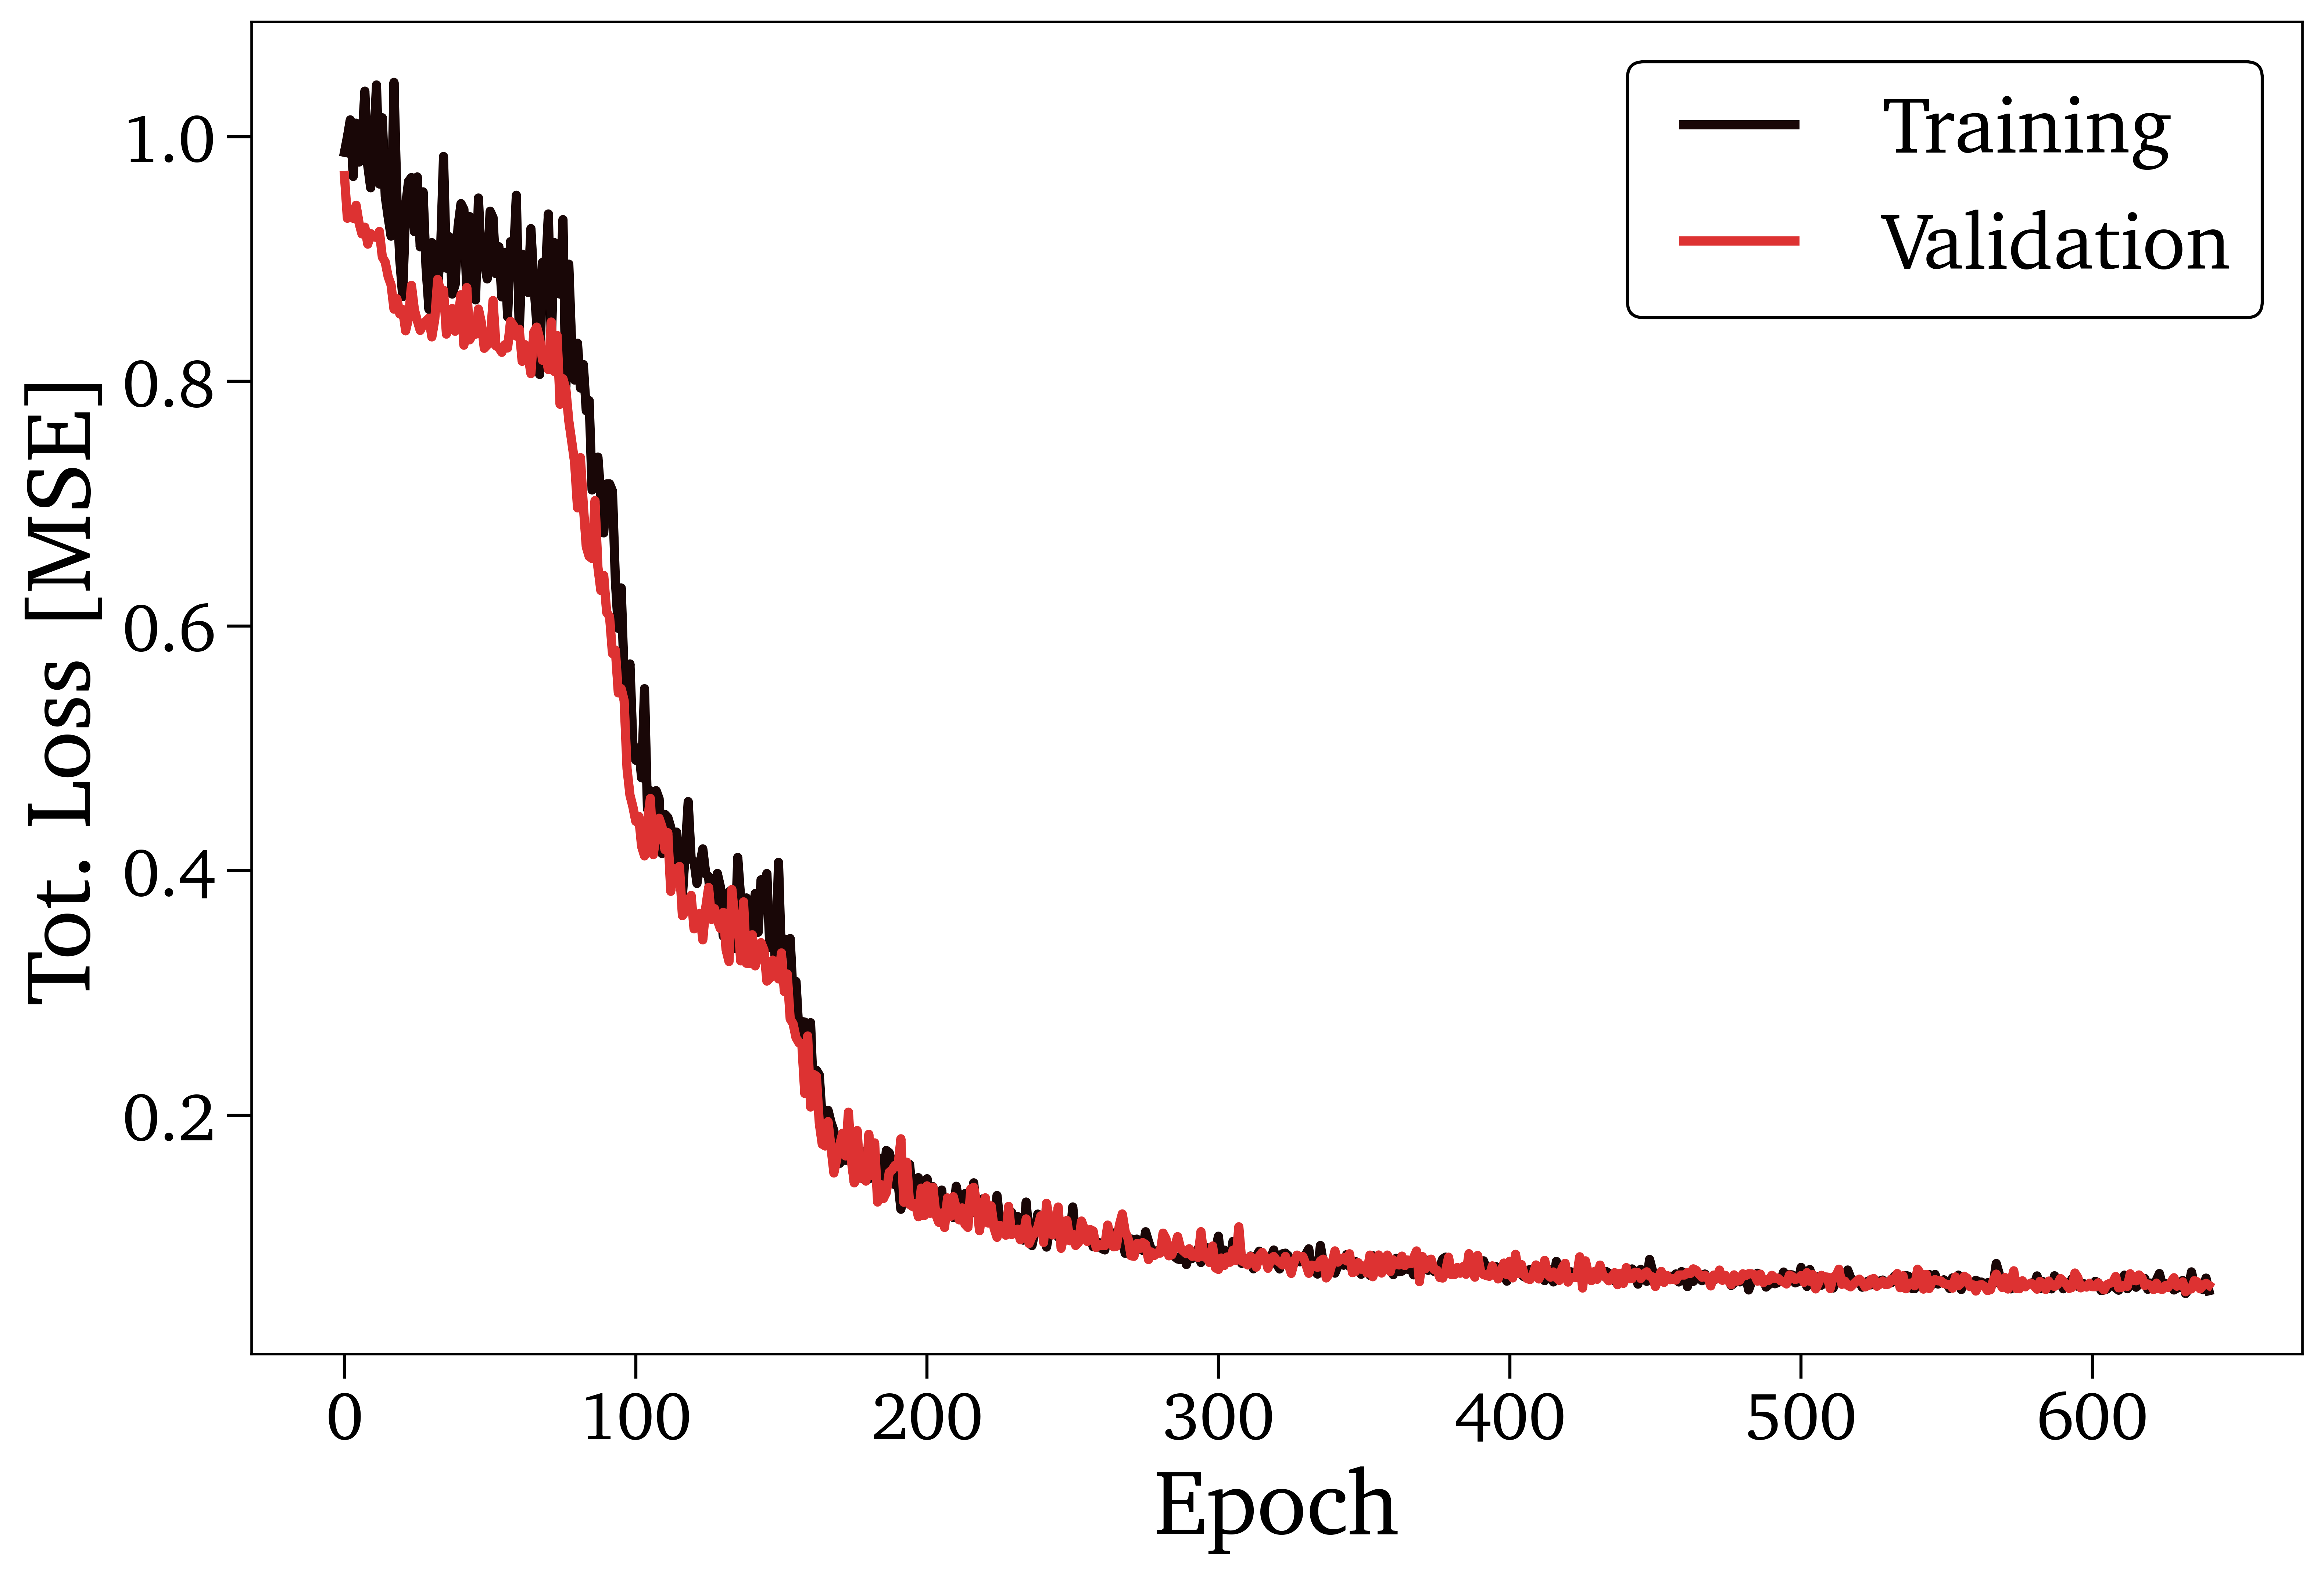

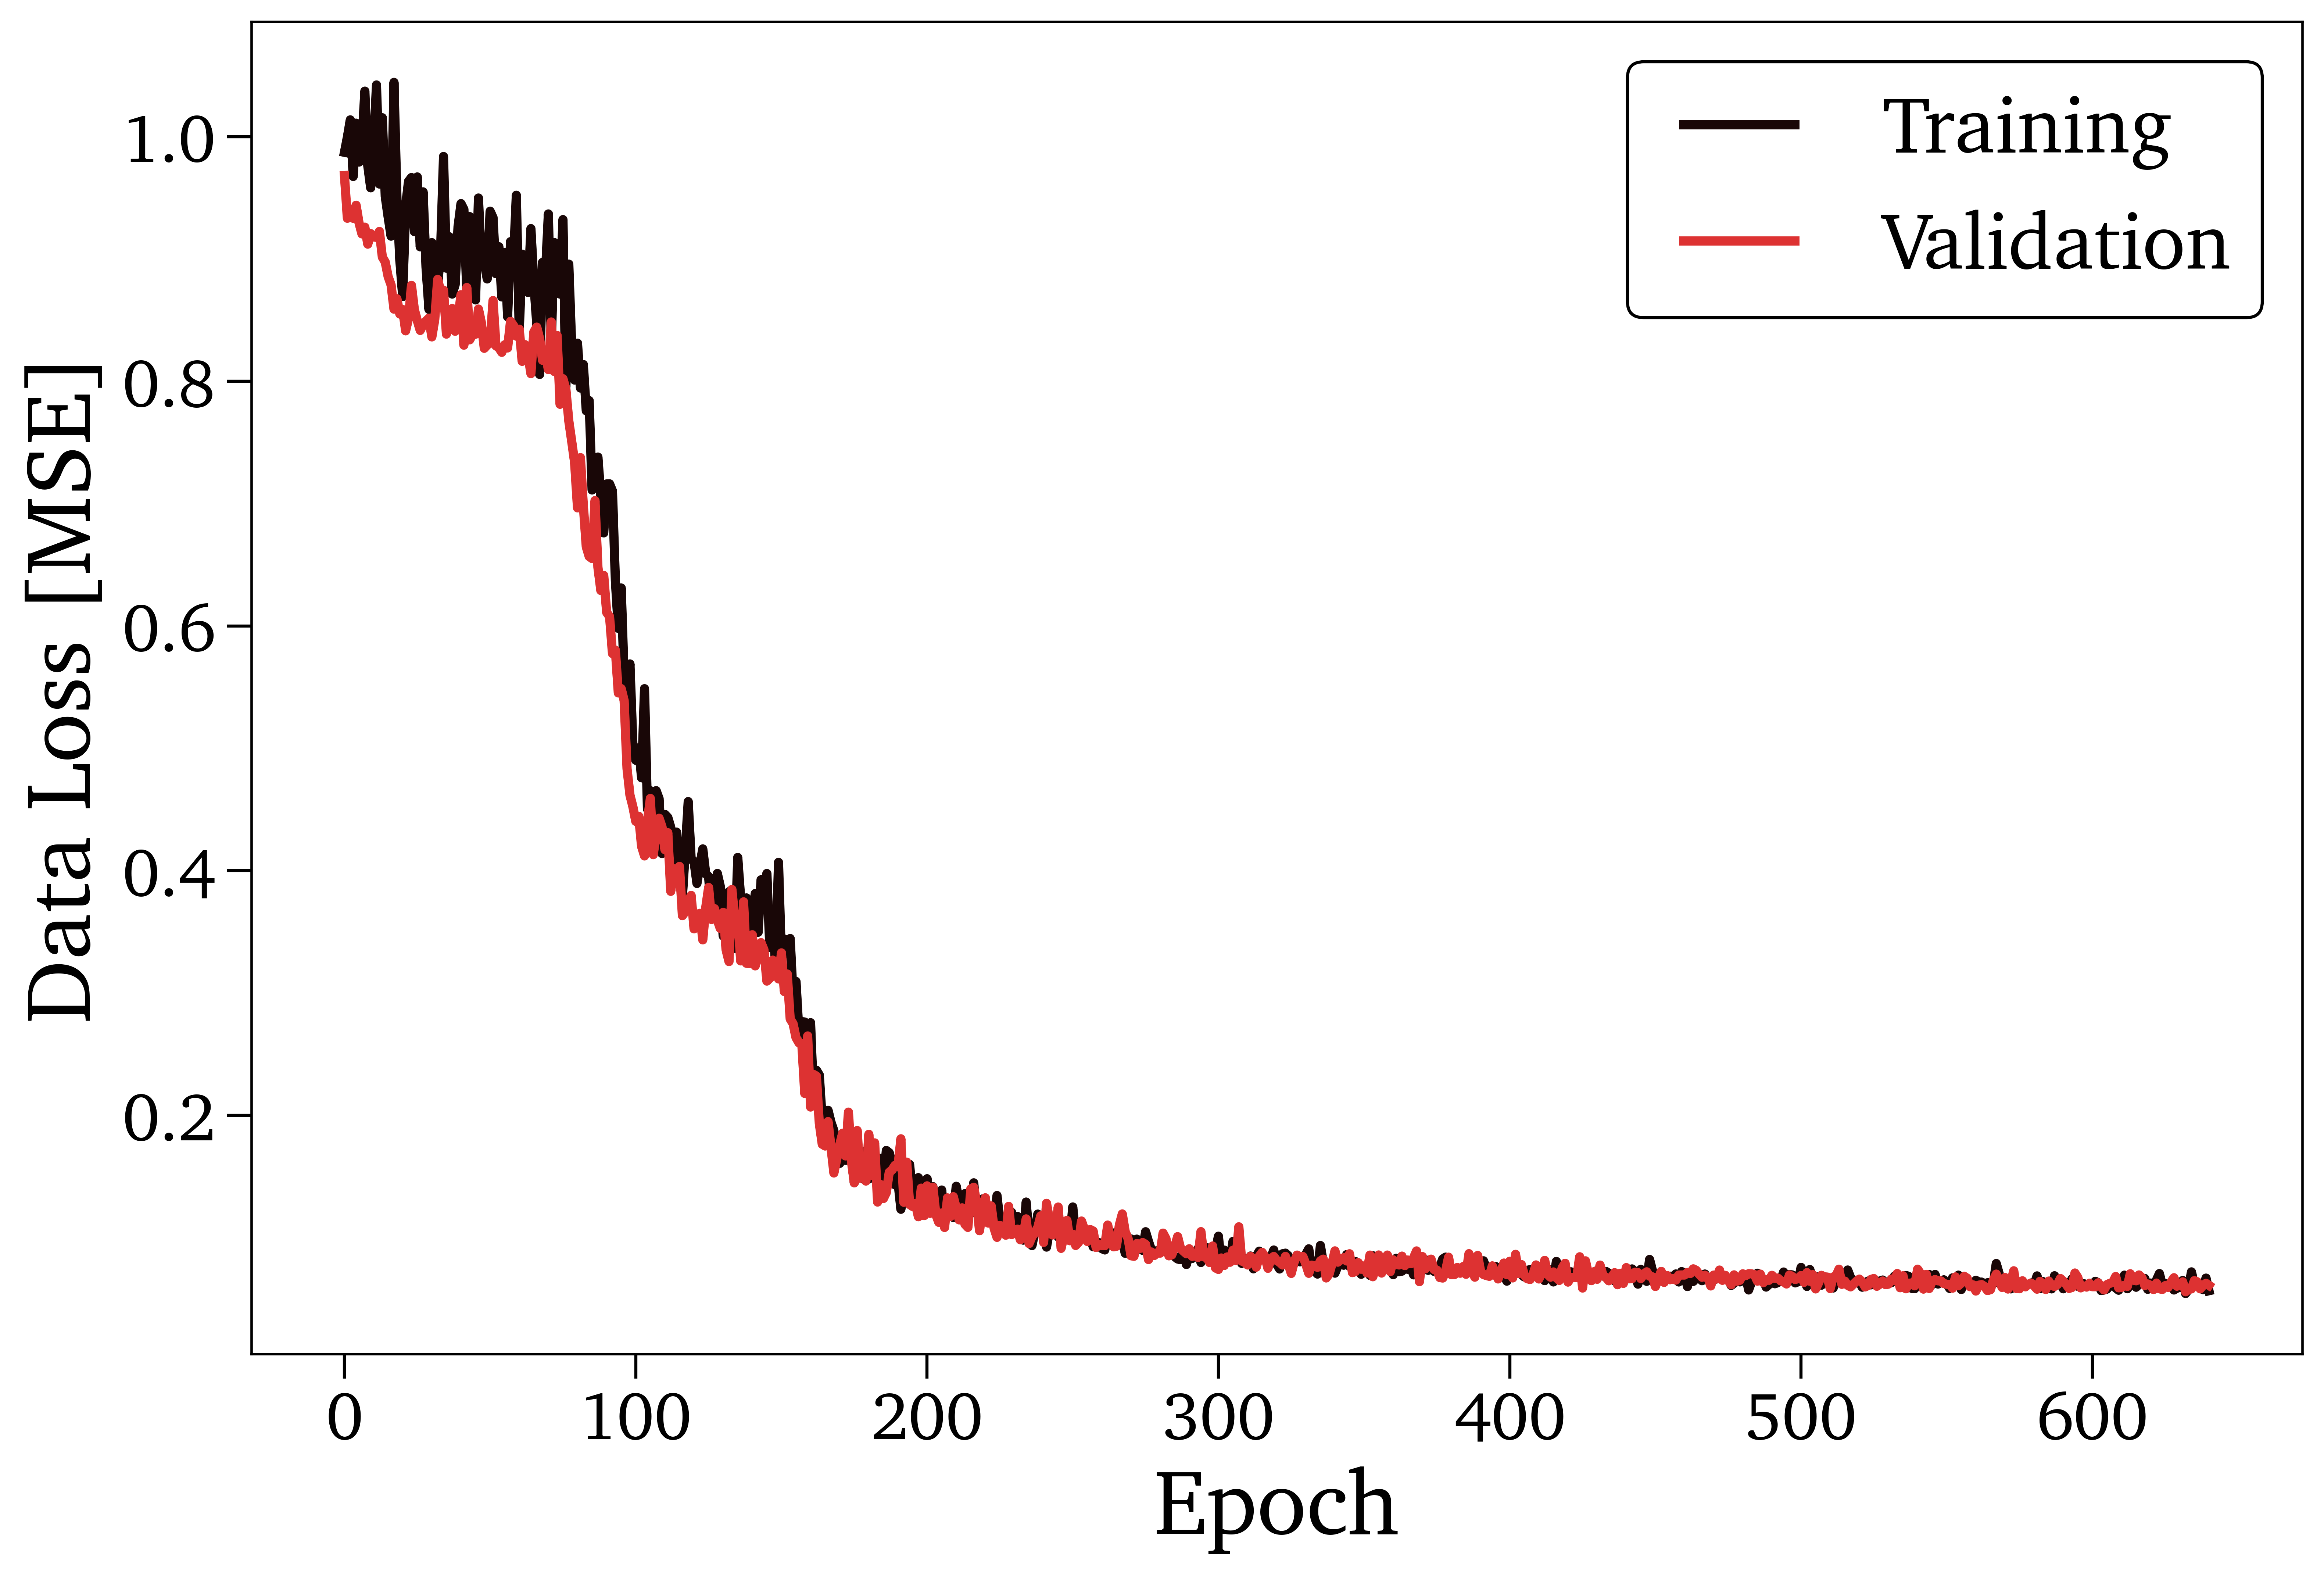

In [11]:
Data = pd.read_csv(path_to_run_fld+'/Training/History.csv')

fig  = plt.figure(figsize=(12,8))
plt.plot(Data['tot_loss'],     label='Training')
plt.plot(Data['val_tot_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Tot. Loss [MSE]')
plt.legend()
#plt.yscale('log')


fig  = plt.figure(figsize=(12,8))
plt.plot(Data['pts_loss'],     label='Training')
plt.plot(Data['val_pts_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Data Loss [MSE]')
plt.legend()
#plt.yscale('log')
#plt.ylim([1.e-2, 1.e0])

# fig  = plt.figure(figsize=(12,8))
# plt.plot(Data['scs_loss'],     label='Training')
# plt.plot(Data['val_scs_loss'], label='Validation')
# plt.xlabel('Epoch')
# plt.ylabel('S.C.s Loss [MSE]')
# plt.legend()
# plt.yscale('log')

# fig  = plt.figure(figsize=(12,8))
# plt.plot(Data['ics_loss'],     label='Training')
# plt.plot(Data['val_ics_loss'], label='Validation')
# plt.xlabel('Epoch')
# plt.ylabel('I.C.s Loss [MSE]')
# plt.legend()
# plt.yscale('log')

## Evaluating Branches' and Trunk's Outputs

In [12]:
FileName   = InputData.path_to_data_fld + '/test/ext/Input.csv'# + InputData.InputFile
DataIn     = pd.read_csv(FileName, header=0)
Input_     = DataIn.to_numpy()
VarNames   = list(DataIn.columns)

FileName   = InputData.path_to_data_fld + '/test/ext/Output.csv'# + InputData.InputFile
Data       = pd.read_csv(FileName, header=0)
Output_    = Data.to_numpy()

In [13]:
FileName  = WORKSPACE_PATH + '/ROMNet/Data/MSD_100Cases/Orig/test/ext/Input.csv'# + InputData.InputFile
Data      = pd.read_csv(FileName, header=0)
Input     = Data[branch_vars].to_numpy()
VarNames  = list(Data.columns)
Nu        = Input.shape[1]
u         = []
for iu in range(Nu):
    u.append(np.unique(Input[:,iu]))
u         = np.stack(u, axis=0).T
n_test     = u.shape[0]


## Variable to Be Visualized
VarOI     = 'v'
for iVar in range(1,len(VarNames)):
    if (VarNames[iVar] == VarOI):
        print('iVar = ', iVar)
        break

iSim = 0
for iTest in range(n_test):#[0,1,2,3,4]:
    
#     ### Generating Data  
#     output     = solve_ivp( fOrig, tout[[0,-1]], u[iTest,:], method=SOLVER, t_eval=tout, rtol=1.e-15, atol=1.e-10 )
#     tOrig      = tout
#     yMatOrig   = output.y.T
    
    ### Creating NN Input
    tPred     = tOrig[...,np.newaxis]
    Nt        = len(tPred)
    uPred     = u[iTest,:]*np.ones((Nt,2))
    InputPred = np.concatenate((uPred,tPred), axis=1)

iVar =  2


Text(0.5, 0.5, '$\\alpha_i$')

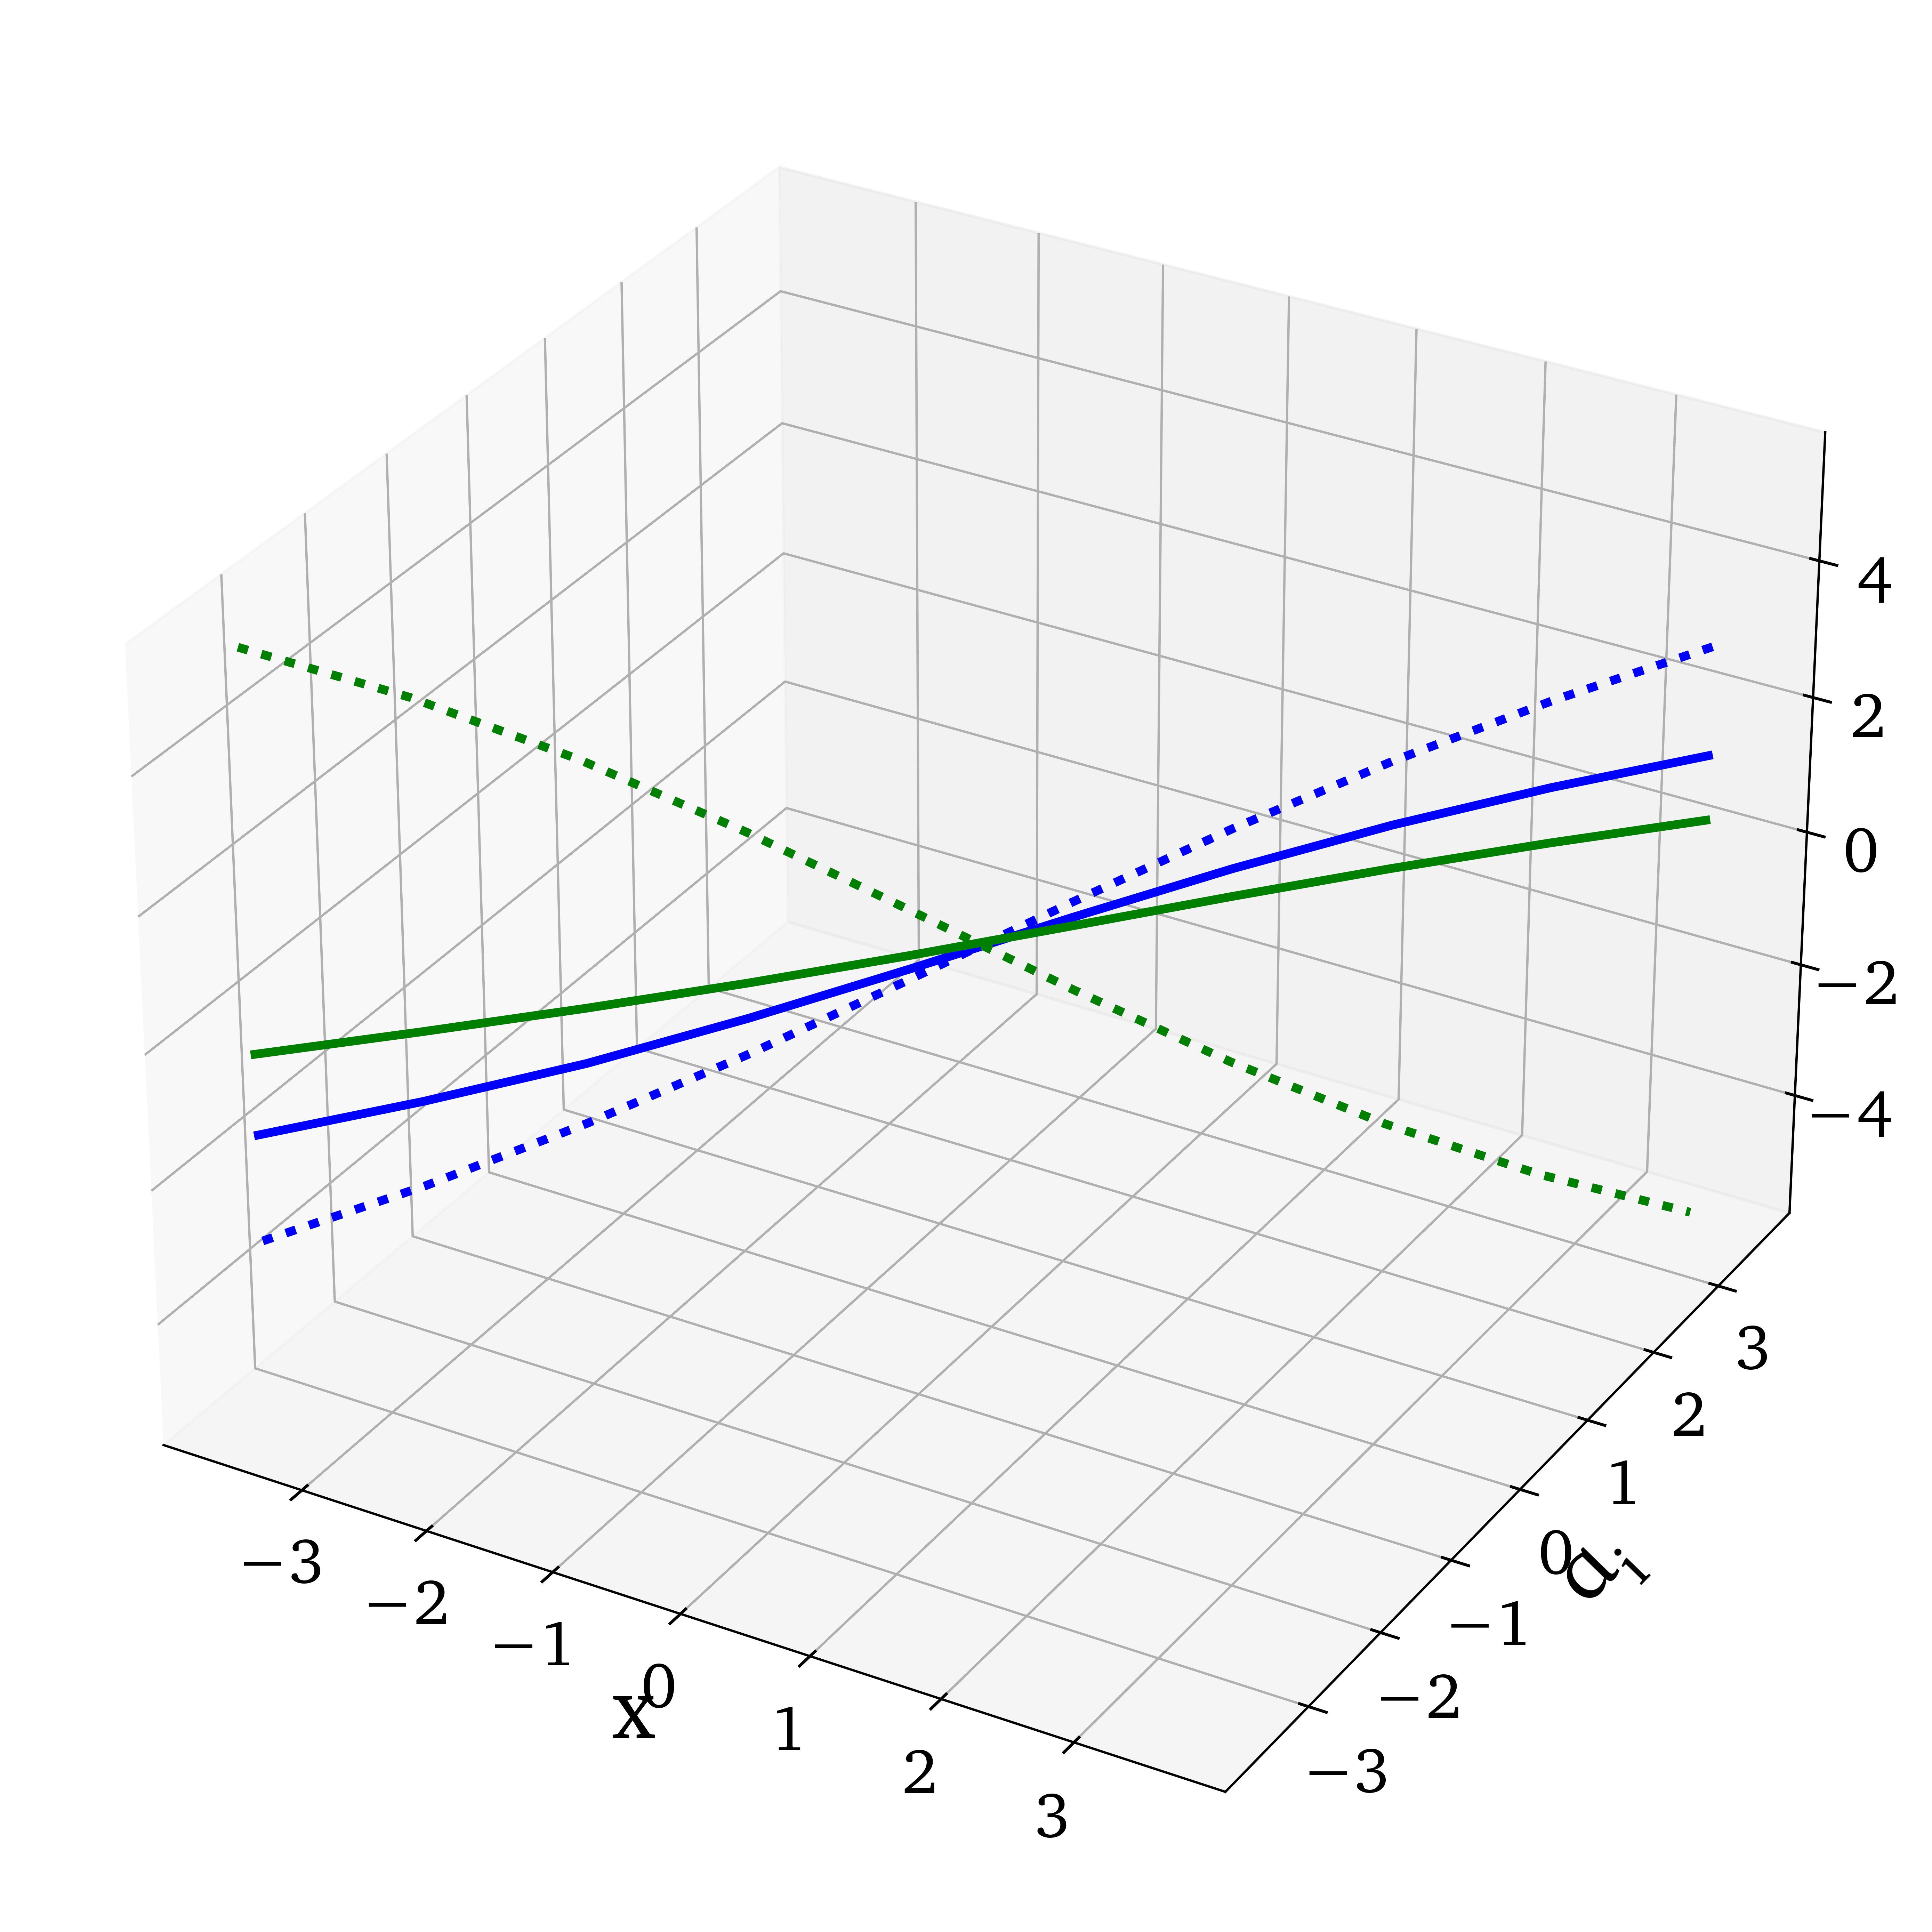

In [14]:
iVar     = 1

output_1 = model.net.system_of_components[ModelType].components['Branch_1'].call(u, model.net.layers_dict, None, None, training=False)
output_2 = model.net.system_of_components[ModelType].components['Branch_2'].call(u, model.net.layers_dict, None, None, training=False)

fig = plt.figure(figsize=(12,12))
ax  = fig.add_subplot(projection='3d')
plt.plot(u[:,0], u[:,1], output_1[:,0], 'b-')
plt.plot(u[:,0], u[:,1], output_1[:,1], 'b:')
plt.plot(u[:,0], u[:,1], output_2[:,0], 'g-')
plt.plot(u[:,0], u[:,1], output_2[:,1], 'g:')
#plt.xlim([1.e-6, 1.e-2])
plt.xlabel(r'x')
plt.ylabel(r'v')
plt.ylabel(r'$\alpha_i$')

KeyError: 'DeepONetMean'

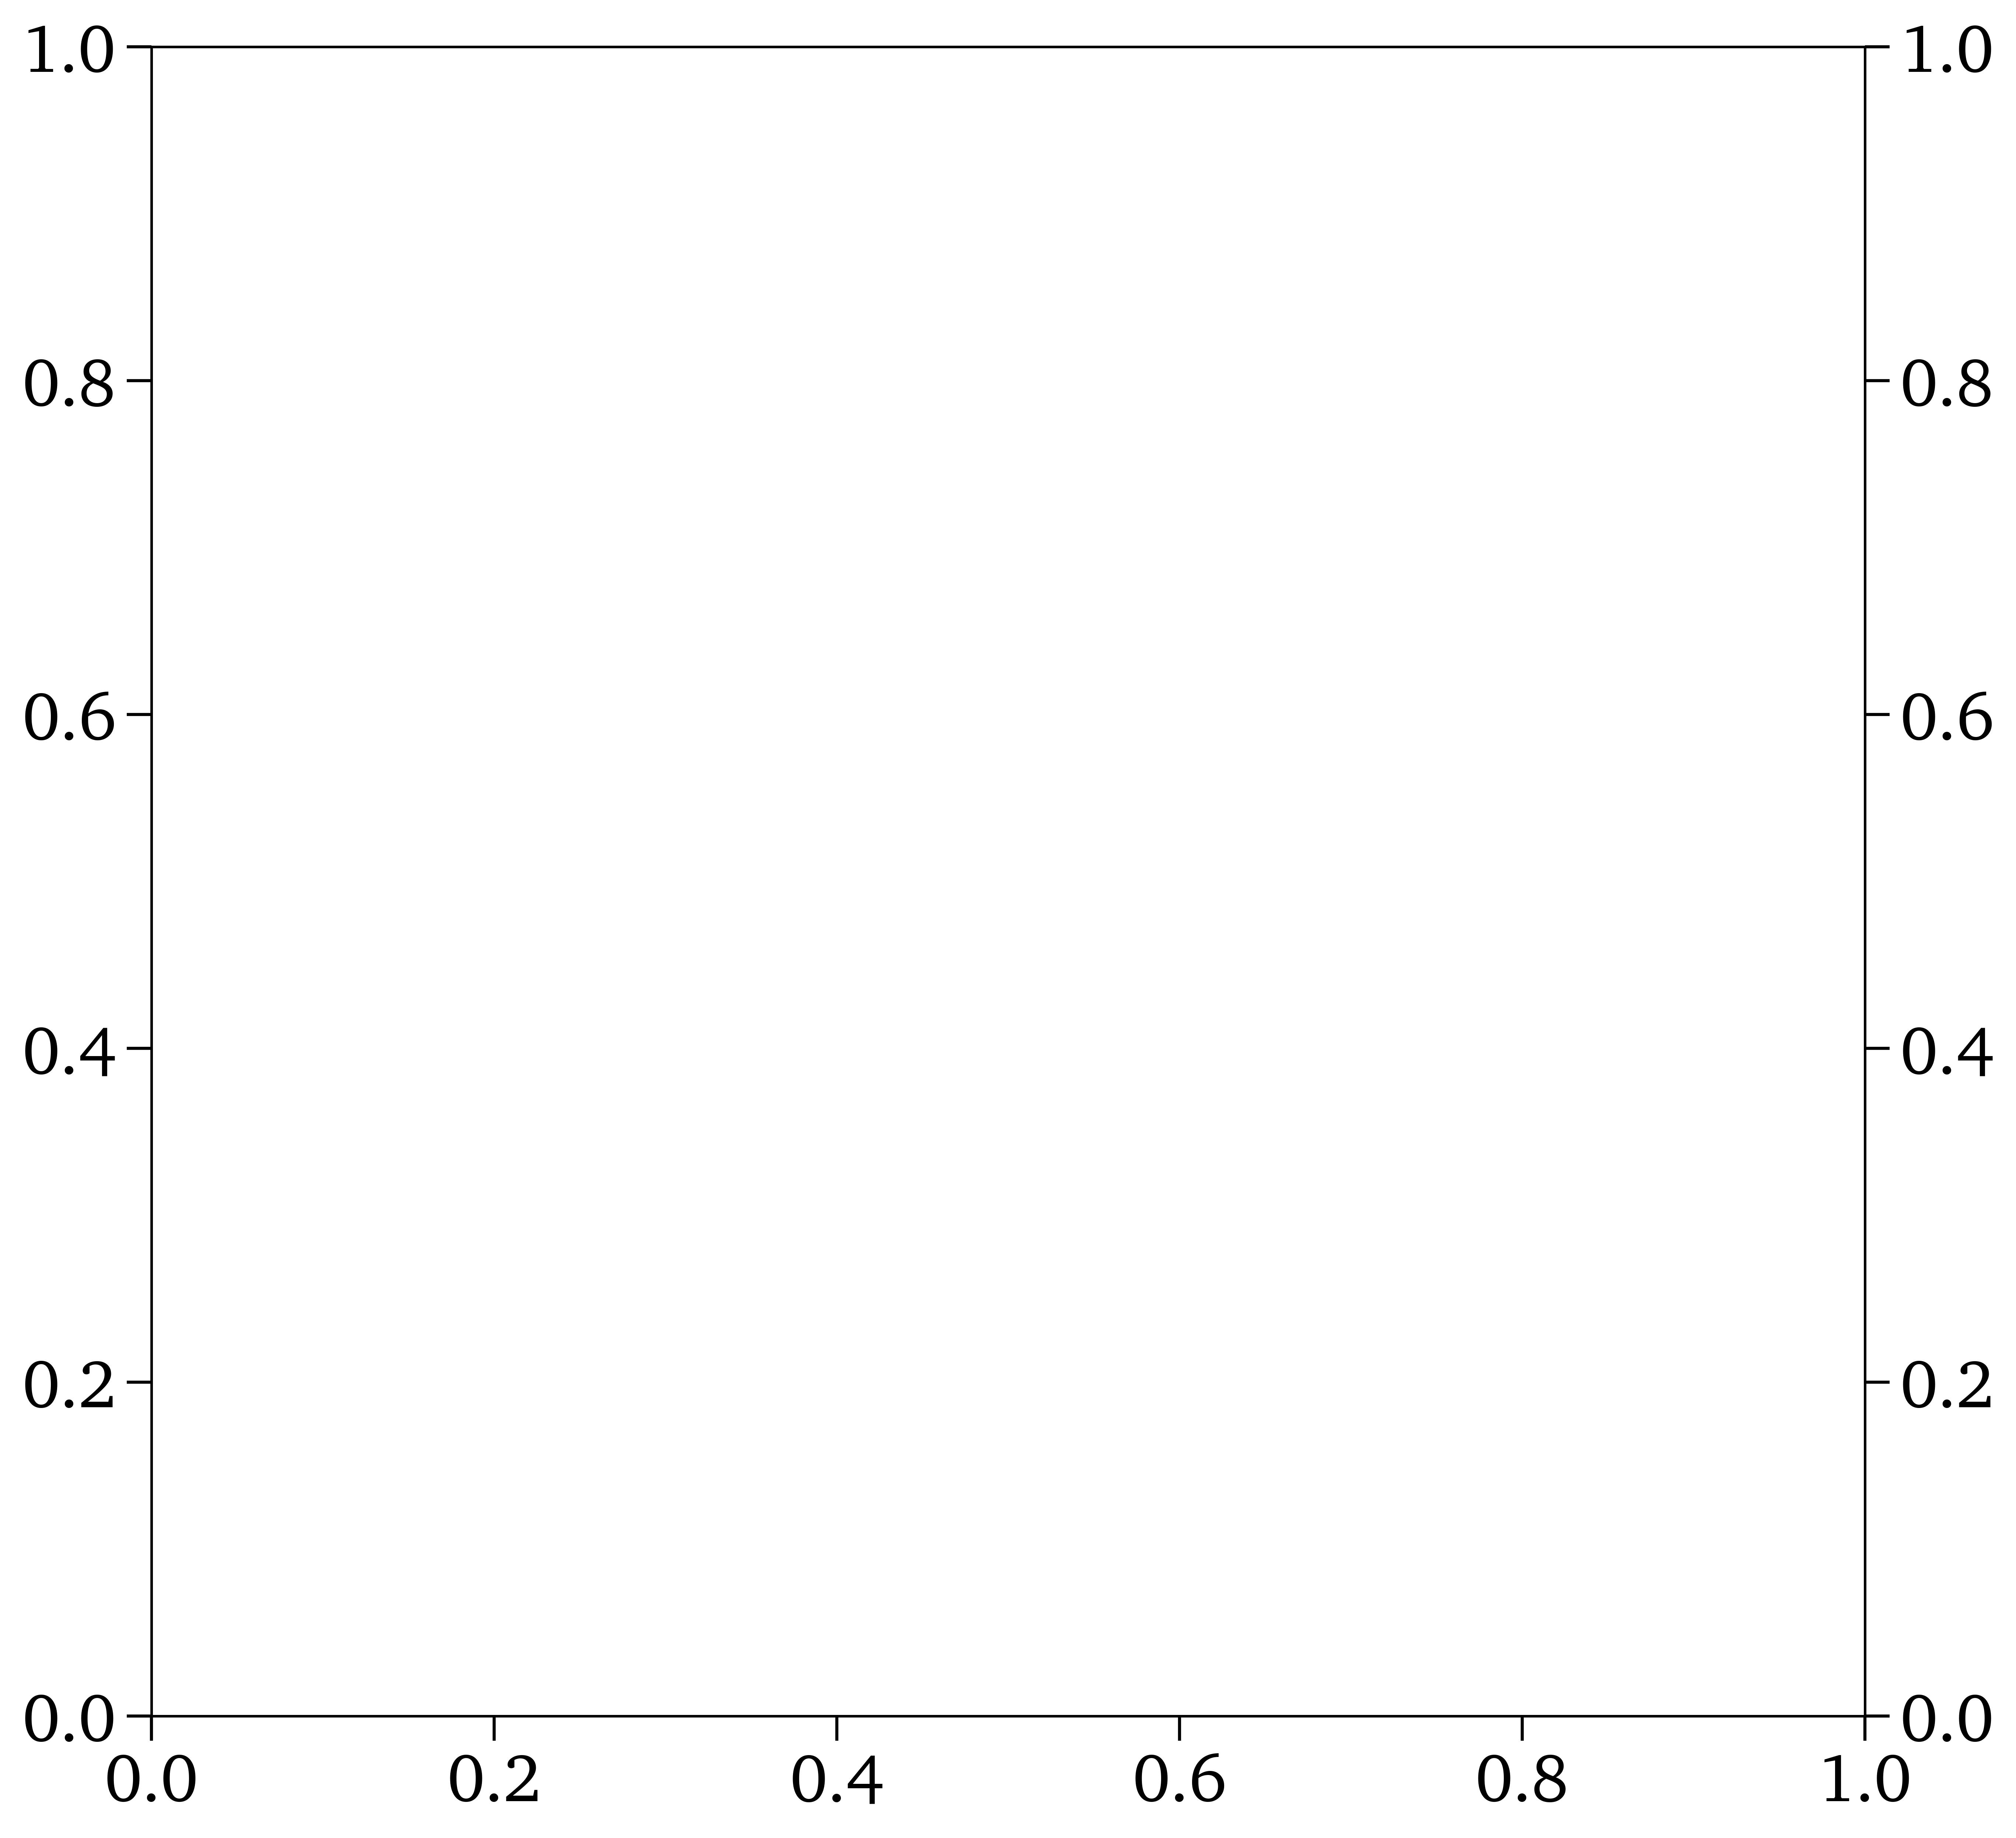

In [15]:
ModelType2 = 'DeepONetMean'

fig, ax1 = plt.subplots()
ax2      = ax1.twinx() 


### Sampling NN
o1_sum = np.zeros((len(tPred), 2))
o1_sqr = np.zeros((len(tPred), 2))
o2_sum = np.zeros((len(tPred), 2))
o2_sqr = np.zeros((len(tPred), 2))

for iSample in range(NSamples):
    o1      = model.net.system_of_components[ModelType2].components['Trunk_1'].call(tPred, model.net.layers_dict, None, None, training=False)
    o1_sum += o1
    o1_sqr += o1**2

    o2      = model.net.system_of_components[ModelType2].components['Trunk_2'].call(tPred, model.net.layers_dict, None, None, training=False)
    o2_sum += o2
    o2_sqr += o2**2


#     ax1.plot(tPred, o1[:,0], '-', color=ColorVec[1], label=Label1)
#     ax1.plot(tPred, o1[:,1], '-', color=ColorVec[1], label=Label2)
#     ax2.plot(tPred, o2[:,0], '-', color=ColorVec[0])
#     ax2.plot(tPred, o2[:,1], '-', color=ColorVec[0])


o1_mean = o1_sum/NSamples
o1_std  = np.sqrt( o1_sqr/NSamples - o1_mean**2 )
o1_p1   = o1_mean + 1.*o1_std
o1_m1   = o1_mean - 1.*o1_std
o1_p2   = o1_mean + 2.*o1_std
o1_m2   = o1_mean - 2.*o1_std
o1_p3   = o1_mean + 3.*o1_std
o1_m3   = o1_mean - 3.*o1_std

o2_mean = o2_sum/NSamples
o2_std  = np.sqrt( o2_sqr/NSamples - o2_mean**2 )
o2_p1   = o2_mean + 1.*o2_std
o2_m1   = o2_mean - 1.*o2_std
o2_p2   = o2_mean + 2.*o2_std
o2_m2   = o2_mean - 2.*o2_std
o2_p3   = o2_mean + 3.*o2_std
o2_m3   = o2_mean - 3.*o2_std

if (iSim == 0):
    Label1 = 'ODE'
    Label2 = 'DeepONet, $\mu$'
    Label3 = 'DeepONet, $\pm 3\sigma$'
    Label4 = 'DeepONet, $\pm 2\sigma$'
    Label5 = 'DeepONet, $\pm \sigma$'
else:
    Label1 = None
    Label2 = None
    Label3 = None
    Label4 = None
    Label5 = None

    
    
# color = ColorVec[1]
# ax1.plot(tPred, o1[:,iVar-1], ':',  color='#DF7401', label=Label2)
# ax1.plot(tPred, o1[:,iVar],   ':',  color='#DF7401', label=None)

# color = ColorVec[0]
# ax1.plot(tPred, o2[:,iVar-1], ':',  color='#848484', label=None)
# ax1.plot(tPred, o2[:,iVar],   ':',  color='#848484', label=None)



color = ColorVec[1]
ax1.fill_between(tPred[:,0], o1_m3[:,iVar-1], o1_p3[:,iVar-1], alpha=.2, color='#DF7401', label=Label3)
ax1.fill_between(tPred[:,0], o1_m2[:,iVar-1], o1_p2[:,iVar-1], alpha=.5, color='#DF7401', label=Label4)
ax1.fill_between(tPred[:,0], o1_m1[:,iVar-1], o1_p1[:,iVar-1], alpha=.8, color='#DF7401', label=Label5)
ax1.plot(tPred, o1_mean[:,iVar-1], ':',  color='#DF7401', label=Label2)

ax1.fill_between(tPred[:,0], o1_m3[:,iVar], o1_p3[:,iVar], alpha=.2, color='#DF7401', label=None)
ax1.fill_between(tPred[:,0], o1_m2[:,iVar], o1_p2[:,iVar], alpha=.5, color='#DF7401', label=None)
ax1.fill_between(tPred[:,0], o1_m1[:,iVar], o1_p1[:,iVar], alpha=.8, color='#DF7401', label=None)
ax1.plot(tPred, o1_mean[:,iVar], ':',  color='#DF7401', label=None)

color = ColorVec[0]
ax1.fill_between(tPred[:,0], o2_m3[:,iVar-1], o2_p3[:,iVar-1], alpha=.2, color='#848484', label=None)
ax1.fill_between(tPred[:,0], o2_m2[:,iVar-1], o2_p2[:,iVar-1], alpha=.5, color='#848484', label=None)
ax1.fill_between(tPred[:,0], o2_m1[:,iVar-1], o2_p1[:,iVar-1], alpha=.8, color='#848484', label=None)
ax1.plot(tPred, o2_mean[:,iVar-1], ':',  color='#848484', label=None)

ax1.fill_between(tPred[:,0], o2_m3[:,iVar], o2_p3[:,iVar], alpha=.2, color='#848484', label=None)
ax1.fill_between(tPred[:,0], o2_m2[:,iVar], o2_p2[:,iVar], alpha=.5, color='#848484', label=None)
ax1.fill_between(tPred[:,0], o2_m1[:,iVar], o2_p1[:,iVar], alpha=.8, color='#848484', label=None)
ax1.plot(tPred, o2_mean[:,iVar], ':',  color='#848484', label=None)


ax1.set_xlabel('Time [s]', size=34)
ax1.set_ylabel(r'$\psi_{x_i}$', color=ColorVec[1], size=34)
ax1.tick_params(axis='y', labelcolor=ColorVec[1])
#ax1.set_ylim([-3.5,3.5])

color = 'k'
ax2.set_ylabel(r'$\psi_{v_i}$', color=ColorVec[0], size=34)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=ColorVec[0])
#ax2.set_ylim([-4.5,4.5])

ax1.legend()


fig.tight_layout()  # otherwise the right y-label is slightly clipped

if (FigDir):
    plt.savefig(FigDir+'//MSD_Trunk_Mode_Dropouts.png', format='png', bbox_inches='tight')